In [ ]:
# !pip install pandas
# !pip install scikit-learn
# !pip install transformers
# !pip install torch torchvision torchaudio
# !pip3 install torch torchvision torchaudio
# !pip install accelerate -U
# !pip install tensorflow

In [91]:
import pandas as pd
import os
import re

# Get all the transcripts in the transcript folder
transcript_folder = './dataset/two_speakers_ID/'  

# Initialize an empty list to collect DataFrames
dfs = []

# Regex pattern to extract patient_id and provider_id from filenames
pattern = re.compile(r'(\d+)_(\d+)_\d+\.csv')

# Iterate through each file in the folder
for filename in os.listdir(transcript_folder):
    if filename.endswith('.csv'):
        # Extract patient_id and provider_id from filename
        match = pattern.match(filename)
        if match:
            patient_id, provider_id = match.groups()
        else:
            continue
        
        # Construct full file path
        file_path = os.path.join(transcript_folder, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Add patient_id and provider_id as new columns
        df['Patient_ID'] = patient_id
        df['Provider_ID'] = provider_id
        
        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# combined_df.to_csv('combined_transcripts.csv', index=False)


In [108]:
combined_df.to_csv('combined_transcripts.csv', index=False)

In [92]:

# Analysis only for SVS
transcript_df = combined_df

# Load the SVS scores data
scores_df = pd.read_csv('./dataset/survey.csv') 

# List of required SVS columns
required_columns = [
    'patient_id','Conservation', 'Conformity', 'Tradition', 'Security', 
    'Self-Transcendance', 'Benevolence', 'Universalism', 
    'Self-Enhancement', 'Power', 'Achievement', 
    'Stimulation', 'Openness to Change', 'Hedonism', 
    'Self-Direction'
]

# Check if all required columns are present in the dataframe
missing_columns = [col for col in required_columns if col not in scores_df.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    # Select only the required columns
    svs_df = scores_df[required_columns]

    # svs_scores_df.to_csv('svs_scores_filtered.csv', index=False)



In [93]:
# Filter out messages from the patient only
patient_transcripts = transcript_df[transcript_df['Role'] == 'Patient']

# Aggregate patient messages by conversation ID
# For simplicity, we'll concatenate all patient messages for each conversation
patient_conversations = patient_transcripts.groupby('ID')['Message'].apply(lambda msgs: ' '.join(msgs)).reset_index()


# marking the fields as int
patient_conversations['ID'] = pd.to_numeric(patient_conversations['ID'], errors='coerce').astype('Int64')
svs_df['patient_id'] = svs_df['patient_id'].str.replace(',', '')
svs_df['patient_id'] = pd.to_numeric(svs_df['patient_id'], errors='coerce').astype('Int64')

# Assuming 'data' is your DataFrame containing the message and target variables
data = pd.merge(patient_conversations, svs_df, left_on='ID', right_on='patient_id')


C:\Users\Waqar\AppData\Local\Temp\ipykernel_15292\368897620.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svs_df['patient_id'] = svs_df['patient_id'].str.replace(',', '')
C:\Users\Waqar\AppData\Local\Temp\ipykernel_15292\368897620.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svs_df['patient_id'] = pd.to_numeric(svs_df['patient_id'], errors='coerce').astype('Int64')


In [98]:

# Extract features and target variable
X = data['Message']
y = data[required_columns].drop(columns='patient_id')

# Handle NaN values
y = y.dropna()
X = X[y.index]

In [99]:
#Linear Regression Model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd


vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train a separate model for each SVS score
models = {}
predictions = pd.DataFrame(index=y_test.index)

for column in y.columns:
    model = LinearRegression()
    model.fit(X_train, y_train[column])
    models[column] = model
    predictions[column] = model.predict(X_test)

for column in y.columns:
    # Drop NaN values from both y_test and predictions for the current column
    valid_indices = y_test[column].dropna().index.intersection(predictions[column].index)
    
    # Align y_test and predictions to valid indices
    y_test_valid = y_test.loc[valid_indices, column]
    predictions_valid = predictions.loc[valid_indices, column]
    
    # Check if valid indices result in non-empty data
    if len(y_test_valid) == 0 or len(predictions_valid) == 0:
        print(f'No valid samples for {column}. Skipping MSE calculation.')
        continue
    
    # Calculate and print the Mean Squared Error
    mse = mean_squared_error(y_test_valid, predictions_valid)
    print(f'Mean Squared Error for {column}: {mse}')

Mean Squared Error for Conservation: 3.7556877901447403
Mean Squared Error for Conformity: 6.302463278568738
Mean Squared Error for Tradition: 3.766440409261476
Mean Squared Error for Security: 5.573490662854732
Mean Squared Error for Self-Transcendance: 2.5189650809495023
Mean Squared Error for Benevolence: 1.6787592863777936
Mean Squared Error for Universalism: 5.195116175895041
Mean Squared Error for Self-Enhancement: 3.7083087444657
Mean Squared Error for Power: 4.89742139947939
Mean Squared Error for Achievement: 4.459321763457823
Mean Squared Error for Stimulation: 5.822897844316516
Mean Squared Error for Openness to Change: 2.533934361992602
Mean Squared Error for Hedonism: 4.547830033094942
Mean Squared Error for Self-Direction: 3.756290026578057


In [113]:
# Deep Learning Keras Model

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Convert text messages to numerical features using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(X)

# Convert target variables to float
y = y.astype(np.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Convert sparse matrix to dense format
X_train_dense = X_train.toarray().astype(np.float32)
X_test_dense = X_test.toarray().astype(np.float32)

# Build and compile the neural network model
models = {}
predictions = pd.DataFrame(index=y_test.index)

for column in y.columns:
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train_dense.shape[1],)),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(1)  # Output layer for regression, one neuron per column
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Set up early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train_dense,
        y_train[column],
        validation_split=0.2,
        epochs=1000,
        batch_size=32,
        callbacks=[early_stopping]
    )

    # Predict on the test set
    predictions[column] = model.predict(X_test_dense).flatten()

    # Calculate and print Mean Squared Error
    mse = mean_squared_error(y_test[column], predictions[column])
    print(f'Mean Squared Error for {column}: {mse}')
    
    # Optionally, plot training history
    # import matplotlib.pyplot as plt

    # plt.plot(history.history['loss'], label='Training Loss')
    # plt.plot(history.history['val_loss'], label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title(f'Training History for {column}')
    # plt.legend()
    # plt.show()


d:\projects\personality-trait\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 37.3919 - val_loss: 35.4118
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 32.2962 - val_loss: 26.3889
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 22.4223 - val_loss: 12.4483
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 9.8331 - val_loss: 5.9880
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 6.6199 - val_loss: 10.8108
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 10.7453 - val_loss: 5.7267
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 3.9056 - val_loss: 6.0129
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 3.5704 - val_loss: 7.6827
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 4.5633 - val_loss: 7.1471
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 3.9612 - val_loss: 5.6805
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1.8897 - val_loss: 5.0369
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step 

d:\projects\personality-trait\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 36.7011 - val_loss: 33.1638
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 29.1762 - val_loss: 22.9374
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 20.2351 - val_loss: 9.7517
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 7.8372 - val_loss: 9.7539
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 10.5237 - val_loss: 9.5153
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 8.5529 - val_loss: 6.5463
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 4.2726 - val_loss: 8.0101
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 4.3653 - val_loss: 8.4775
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 4.4792 - val_loss: 7.1995
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 2.3655 - val_loss: 6.3033
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 2.0148 - val_loss: 6.2733
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 1.5687 

d:\projects\personality-trait\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - loss: 37.3218 - val_loss: 35.4293
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 32.0660 - val_loss: 26.9086
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 21.5288 - val_loss: 13.4847
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 9.7926 - val_loss: 7.1868
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 7.2993 - val_loss: 10.8456
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 10.2942 - val_loss: 7.2066
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 4.7766 - val_loss: 8.2371
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 4.1438 - val_loss: 9.8802
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 5.5151 - val_loss: 9.0793
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 4.0580 - val_loss: 7.6528
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 2.5550 - val_loss: 7.3642
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 2.6342

d:\projects\personality-trait\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 45.4464 - val_loss: 40.2914
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 38.9071 - val_loss: 31.6291
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 29.2976 - val_loss: 17.2605
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 14.4236 - val_loss: 5.8808
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 7.5724 - val_loss: 11.4566
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 10.1989 - val_loss: 6.7563
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 5.1362 - val_loss: 5.6363
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 3.7530 - val_loss: 7.2246
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step - loss: 5.1005 - val_loss: 7.2870
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 3.8195 - val_loss: 5.6218
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 2.4511 - val_loss: 4.5983
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/

d:\projects\personality-trait\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - loss: 45.2157 - val_loss: 44.6085
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 39.6082 - val_loss: 34.3174
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 28.7655 - val_loss: 17.0495
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 13.2556 - val_loss: 3.1225
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 5.6643 - val_loss: 7.9027
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 10.5791 - val_loss: 3.3226
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 3.3864 - val_loss: 4.4023
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 3.9464 - val_loss: 7.1697
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 5.3188 - val_loss: 6.8179
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 3.6522 - val_loss: 4.5065
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 2.4688 - val_loss: 2.7485
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms

d:\projects\personality-trait\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 508ms/step - loss: 51.9028 - val_loss: 51.2657
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 46.6646 - val_loss: 41.4614
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 37.0614 - val_loss: 24.4020
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 19.1696 - val_loss: 5.8711
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 5.1090 - val_loss: 8.7163
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 11.3705 - val_loss: 6.1401
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 7.3481 - val_loss: 4.1609
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 3.6779 - val_loss: 7.4610
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 6.0329 - val_loss: 8.5638
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 5.8602 - val_loss: 6.5833
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 3.8704 - val_loss: 3.9977
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - lo

d:\projects\personality-trait\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - loss: 40.8321 - val_loss: 41.8860
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 39.2279 - val_loss: 36.7774
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 32.5102 - val_loss: 27.1790
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 23.6102 - val_loss: 13.1819
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 10.5893 - val_loss: 3.4752
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 6.4747 - val_loss: 6.3236
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 7.7718 - val_loss: 3.9823
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 6.5652 - val_loss: 3.7684
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 3.6462 - val_loss: 5.3903
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 3.5717 - val_loss: 5.7234
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 3.7493 - val_loss: 4.7211
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 3.

d:\projects\personality-trait\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 25.3107 - val_loss: 20.0621
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 22.8266 - val_loss: 15.0537
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 16.7955 - val_loss: 7.5527
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 7.9718 - val_loss: 4.0828
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 7.1622 - val_loss: 7.1323
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 8.4256 - val_loss: 4.2248
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 4.6038 - val_loss: 3.5378
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 3.1232 - val_loss: 3.9078
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 2.8997 - val_loss: 3.8223
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 3.4372 - val_loss: 3.3576
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 2.2508 - val_loss: 3.1959
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - 

d:\projects\personality-trait\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - loss: 18.3651 - val_loss: 12.4571
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 15.3705 - val_loss: 9.4927
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 12.1896 - val_loss: 6.1499
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 7.2764 - val_loss: 7.7704
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 6.8834 - val_loss: 8.8964
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 7.5098 - val_loss: 6.3240
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 4.2718 - val_loss: 5.3317
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 4.1086 - val_loss: 5.2589
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 3.8845 - val_loss: 5.1118
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 3.2192 - val_loss: 5.1126
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 2.6488 - val_loss: 5.4862
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.227

d:\projects\personality-trait\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 38.4159 - val_loss: 36.9286
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 32.5790 - val_loss: 29.6669
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 26.0727 - val_loss: 17.6274
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 13.4692 - val_loss: 7.0349
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 7.3447 - val_loss: 8.7660
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 9.8345 - val_loss: 6.9537
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 6.4501 - val_loss: 7.3394
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 4.9426 - val_loss: 8.9705
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 3.7880 - val_loss: 8.8569
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 3.6797 - val_loss: 7.4908
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 2.9364 - val_loss: 6.8071
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 2.2

d:\projects\personality-trait\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 25.4705 - val_loss: 27.6059
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 25.6362 - val_loss: 23.0121
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 20.2811 - val_loss: 15.2793
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 12.6282 - val_loss: 7.0867
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 6.6371 - val_loss: 7.1869
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 10.9306 - val_loss: 6.4401
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 8.1141 - val_loss: 5.4821
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 4.8746 - val_loss: 7.5708
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 5.4048 - val_loss: 8.5849
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 5.5114 - val_loss: 7.6566
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 4.5143 - val_loss: 5.7776
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 2.

d:\projects\personality-trait\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - loss: 32.9526 - val_loss: 29.0185
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 28.3577 - val_loss: 20.4077
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 17.7925 - val_loss: 8.5126
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 7.1272 - val_loss: 5.9784
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 7.7609 - val_loss: 7.5904
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 9.2741 - val_loss: 4.4292
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 3.5614 - val_loss: 5.3924
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 3.5893 - val_loss: 5.9892
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 3.7725 - val_loss: 5.1126
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.4033 - val_loss: 4.0915
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 1.8235 - val_loss: 3.7034
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 1.370

d:\projects\personality-trait\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - loss: 33.8830 - val_loss: 22.7685
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 30.1876 - val_loss: 18.2898
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 24.3563 - val_loss: 11.0015
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 15.4567 - val_loss: 5.7248
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 8.1257 - val_loss: 10.7468
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 9.6650 - val_loss: 9.7148
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 7.8358 - val_loss: 6.2949
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.9633 - val_loss: 5.5194
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 4.8512 - val_loss: 5.5371
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 4.2809 - val_loss: 5.4959
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 2.9160 - val_loss: 5.6228
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88

d:\projects\personality-trait\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 323ms/step - loss: 44.8972 - val_loss: 48.7962
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 40.7213 - val_loss: 39.5253
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 28.8546 - val_loss: 23.8005
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 14.4718 - val_loss: 8.3385
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 5.2716 - val_loss: 12.5730
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 12.9338 - val_loss: 8.9285
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.1562 - val_loss: 7.5843
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 3.0801 - val_loss: 10.6938
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 4.8776 - val_loss: 11.8818
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 5.5277 - val_loss: 10.1751
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 3.6823 - val_loss: 7.7433
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step 

In [ ]:
!pip install matplotlib

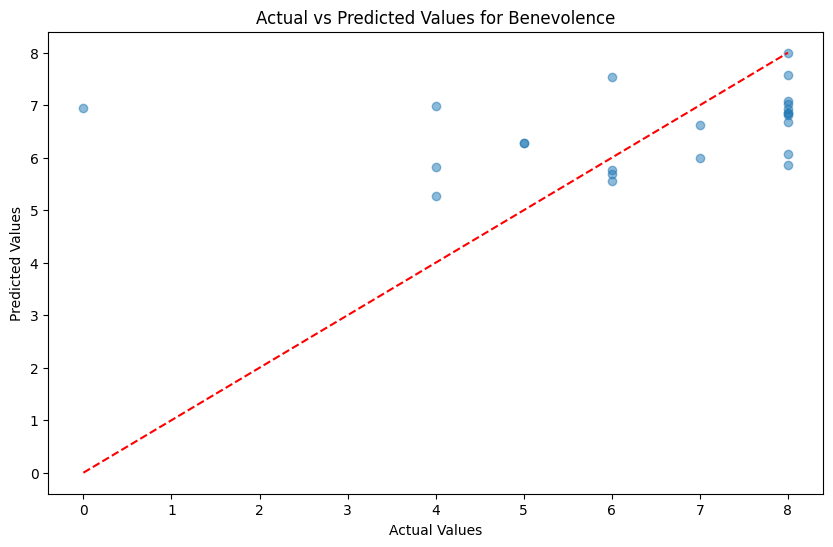

In [112]:
import matplotlib.pyplot as plt

# Example for one SVS score, e.g., 'Benevolence'
score = 'Benevolence'
plt.figure(figsize=(10, 6))
plt.scatter(y_test_valid, predictions_valid, alpha=0.5)
plt.plot([min(y_test_valid), max(y_test_valid)], [min(y_test_valid), max(y_test_valid)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values for {score}')
plt.show()


In [4]:
# Using Transformers

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset

# Convert target variables to float
y = y.astype(np.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = torch.tensor(self.labels.iloc[idx].values).float()
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label
        }

# Load a pre-trained tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=y.shape[1])

# Prepare datasets
train_dataset = TextDataset(X_train, y_train, tokenizer, max_len=128)
test_dataset = TextDataset(X_test, y_test, tokenizer, max_len=128)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

# Predict on the test set
predictions = trainer.predict(test_dataset)
predictions_logits = predictions.predictions

# Calculate Mean Squared Error for each column
for i, column in enumerate(y.columns):
    mse = mean_squared_error(y_test[column], predictions_logits[:, i])
    print(f'Mean Squared Error for {column}: {mse}')

# Optionally, save the model and tokenizer
# model.save_pretrained('./saved_model')
# tokenizer.save_pretrained('./saved_model')


d:\projects\personality-trait\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\projects\personality-trait\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

{'eval_loss': -2.447676420211792, 'eval_runtime': 10.1511, 'eval_samples_per_second': 2.266, 'eval_steps_per_second': 0.296, 'epoch': 1.0}


                                               
 67%|██████▋   | 24/36 [04:18<01:59,  9.92s/it]

{'eval_loss': -5.031106948852539, 'eval_runtime': 10.0185, 'eval_samples_per_second': 2.296, 'eval_steps_per_second': 0.299, 'epoch': 2.0}


                                               
100%|██████████| 36/36 [07:02<00:00, 11.73s/it]


{'eval_loss': -5.7651166915893555, 'eval_runtime': 11.8526, 'eval_samples_per_second': 1.94, 'eval_steps_per_second': 0.253, 'epoch': 3.0}
{'train_runtime': 422.3139, 'train_samples_per_second': 0.632, 'train_steps_per_second': 0.085, 'train_loss': -3.0619994269476996, 'epoch': 3.0}


100%|██████████| 3/3 [00:06<00:00,  2.23s/it]

Mean Squared Error for Conservation: 18.69681167602539
Mean Squared Error for Conformity: 21.470775604248047
Mean Squared Error for Tradition: 21.133760452270508
Mean Squared Error for Security: 23.72403335571289
Mean Squared Error for Self-Transcendance: 28.626449584960938
Mean Squared Error for Benevolence: 37.971622467041016
Mean Squared Error for Universalism: 29.052845001220703
Mean Squared Error for Self-Enhancement: 14.754504203796387
Mean Squared Error for Power: 12.910859107971191
Mean Squared Error for Achievement: 25.12451171875
Mean Squared Error for Stimulation: 21.18195343017578
Mean Squared Error for Openness to Change: 18.74834632873535
Mean Squared Error for Hedonism: 18.279821395874023
Mean Squared Error for Self-Direction: 28.103839874267578
